In [1]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


start_date = datetime(2023, 9, 4, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 17, 23, 59, 59).replace(tzinfo=timezone.utc)

sensor_id = 3

acropolis_path = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"
picarro_path = r"/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/PICARRO"

#Calibration
picarro_slope = 1.0061589132696314
picarro_intercept = 0.14607153970888476


#1.0231831737129127, -9.90156257190614
acropolis_slope = 1.0231831737129127
acropolis_intercept = -9.90156257190614

In [2]:
df = pl.scan_parquet(os.path.join(acropolis_path, "old_db_renamed_measurements.parquet"))

df_a = df.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_a = df_a.with_columns((pl.col("gmp343_compensated") * acropolis_slope + acropolis_intercept).alias("gmp343_compensated_corr"))

df_a.tail(3).collect()

integer,creation_timestamp,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,gas_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,gmp343_compensated_corr
i64,"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9217825,2023-09-08 09:15:51.990 UTC,"""tum-esm-midcos…","""system""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.036,0.305,50.1,32.16,961.86,31.09,null
9218664,2023-09-08 09:23:54.550 UTC,"""tum-esm-midcos…","""system""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.035,0.305,50.6,32.39,961.77,30.91,null
9219506,2023-09-08 09:31:57.080 UTC,"""tum-esm-midcos…","""system""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.035,0.305,51.1,32.58,961.84,30.77,null


In [3]:
df = pl.scan_parquet(os.path.join(picarro_path, "picarro.parquet"))
df = df.with_columns(pl.col("datetime").dt.cast_time_unit("us").dt.replace_time_zone("UTC").alias("creation_timestamp"))

df_p = df.sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_p = df_p.with_columns((pl.col("CO2_dry") * picarro_slope + picarro_intercept).alias("CO2_corr"))

df_p.tail(3).collect()

DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,creation_timestamp,CO2_corr
str,str,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],i64,"datetime[μs, UTC]",f64
"""2023-09-17""","""23:59:53.532""",259.999925,6239.998203,260.999925,1.6950e9,0,963,139.965805,44.999809,43.25,45.153893,2.0,22381.802734,2.058036,2.101561,443.099649,454.569341,2.012013,1181.348031,77.800389,1084.623504,61.172174,-0.074831,-0.044715,2023-09-17 23:59:53.532,3612396,2023-09-17 23:59:53.532 UTC,457.515066
"""2023-09-17""","""23:59:54.447""",259.999936,6239.998458,260.999936,1.6950e9,0,963,139.965805,44.999809,43.25,45.153893,1.0,22381.802734,2.058036,2.101561,443.139285,454.569341,2.012013,1181.348031,77.800389,1084.60733,59.320582,-0.074821,-0.044715,2023-09-17 23:59:54.447,3612397,2023-09-17 23:59:54.447 UTC,457.515066
"""2023-09-17""","""23:59:54.948""",259.999942,6239.998597,260.999942,1.6950e9,0,963,139.965805,44.999809,43.25,45.153893,3.0,22381.802734,2.058036,2.101606,443.139285,454.610269,2.012919,1181.348031,77.800389,1084.60733,59.320582,-0.074821,-0.044715,2023-09-17 23:59:54.948,3612398,2023-09-17 23:59:54.948 UTC,457.556246


In [4]:
filter = '1h'

df_a = df_a.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

df_p = df_p.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

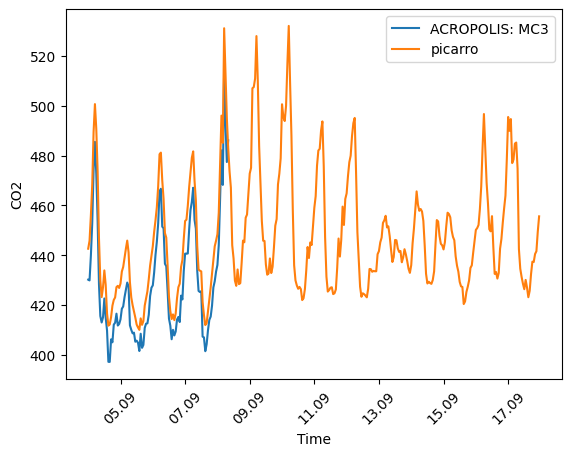

In [5]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="gmp343_compensated_corr", label = f"ACROPOLIS: MC{sensor_id}")
sns.lineplot(data=df_p.collect(), x="creation_timestamp", y="CO2_corr", label = "picarro")

# set axes labels
plt.xlabel("Time")
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# show the plot
plt.show()

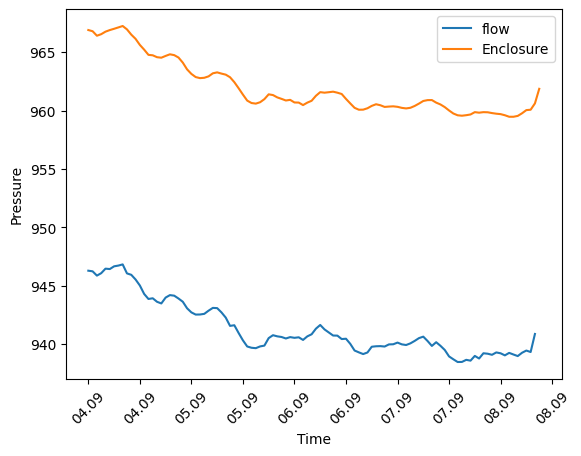

In [6]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="bme280_pressure", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_pressure", label = f"Enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Pressure')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

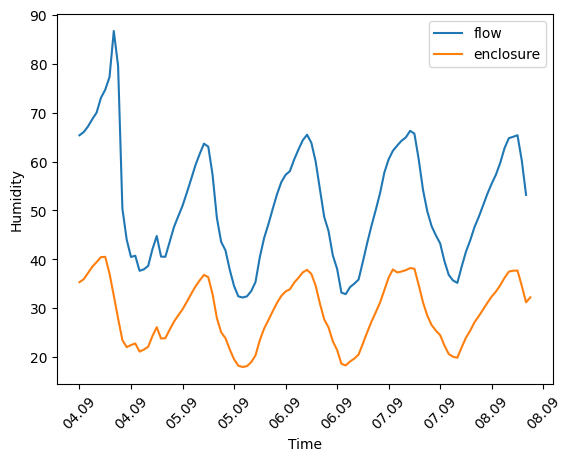

In [7]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_humidity", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_humidity", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Humidity')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

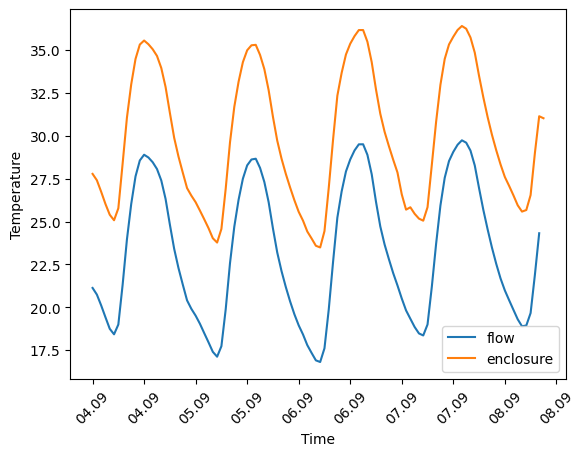

In [8]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_temperature", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_temperature", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

In [9]:
df = df_a.join(df_p, left_on= "creation_timestamp", right_on= "creation_timestamp")
df.tail(3).collect()

creation_timestamp,integer,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,gas_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,gmp343_compensated_corr,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,CO2_corr
"datetime[μs, UTC]",f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
2023-09-08 07:00:00 UTC,9.2063e6,null,null,434.905292,476.280223,476.280223,60.240028,59.024708,939.310279,21.89337,21.7061,23.859053,null,0.27037,0.311111,0.214815,253.444444,265.222222,237.518519,1.6942e9,0.03363,0.305,50.866667,34.608889,960.068519,28.996667,477.420347,null,null,250.312706,6007.504953,251.312706,1.6942e9,0.0,963.0,140.000423,45.000069,42.679824,45.154742,2.016533,22554.271893,2.180318,2.22645,479.568922,491.96509,2.012101,1181.518425,82.761531,1084.825337,62.58499,-0.074685,-0.04476,null,3955707.5,495.141131
2023-09-08 08:00:00 UTC,9.2121e6,null,null,439.914068,484.777567,484.777567,53.188745,51.342167,940.856806,24.319049,24.118517,26.175665,null,0.255,0.295,0.22,257.9,263.9,256.55,1.6942e9,0.034815,0.305,51.992593,31.223704,960.610741,31.143704,486.114687,null,null,250.354234,6008.501617,251.354234,1.6942e9,0.0,963.0,139.998294,44.999892,42.188824,45.154284,2.007736,22531.76434,2.155751,2.202179,467.814968,480.144452,2.043002,1181.5281,82.489256,1084.823253,62.033448,-0.074676,-0.044734,null,3.957675e6,483.247692
2023-09-08 09:00:00 UTC,9.2182e6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.03525,0.305,50.975,32.245,961.86,31.0275,null,null,null,250.395779,6009.498691,251.395779,1.6942e9,0.0,963.0,140.000267,45.000136,42.862047,45.155181,2.028529,22569.61462,2.135596,2.182186,458.494766,470.722546,2.069536,1181.561721,80.302517,1084.831291,62.93862,-0.074678,-0.044722,null,3959643.5,473.767757


<Axes: xlabel='gmp343_compensated_corr', ylabel='CO2_corr'>

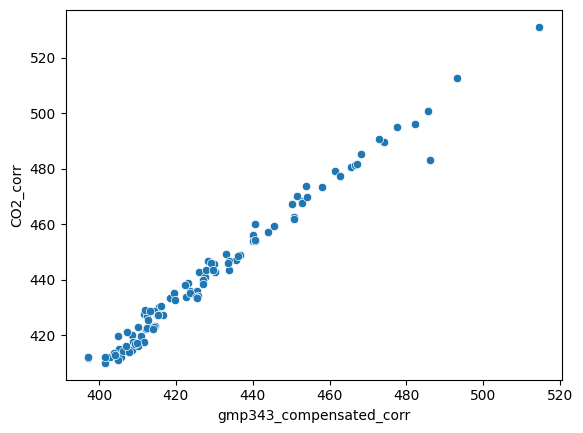

In [10]:
sns.scatterplot(data = df.collect(), x= "gmp343_compensated_corr", y = "CO2_corr" )